In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from glob import glob
import MDAnalysis as mda
from MDAnalysis.analysis import distances
import warnings
warnings.filterwarnings('ignore')
import scipy.sparse
from natsort import natsorted
from MDAnalysis.lib.distances import (
           capped_distance,
           self_distance_array, distance_array,  # legacy reasons
)
from MDAnalysis.lib.c_distances import contact_matrix_no_pbc, contact_matrix_pbc
from MDAnalysis.lib.NeighborSearch import AtomNeighborSearch
from MDAnalysis.lib.distances import calc_bonds
import logging
logger = logging.getLogger("MDAnalysis.analysis.distances")
import os, subprocess
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from rdkit.Chem import DataStructs,AllChem
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
from IPython import embed as e
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdMolDescriptors import CalcNumAromaticRings
from rdkit.Chem.rdMolDescriptors import CalcNumAromaticHeterocycles
from rdkit.Chem.rdMolDescriptors import CalcNumAtoms
import seaborn as sns

/home/juan/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/juan/myenv/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [9]:
import pandas as pd

# Read the datasets
data = pd.read_csv('/home/juan/Documents/Master_Project/data/dataset_06_Dec_ALL.csv')
data2 = pd.read_csv('/home/juan/Documents/Master_Project/data/dataset-30-Jan-22.csv')

# Get the number of features and their names for each dataset
num_features_data1 = len(data.columns)
feature_names_data1 = data.columns.tolist()

num_features_data2 = len(data2.columns)
feature_names_data2 = data2.columns.tolist()

# Print the number of features and their names for each dataset
print("Number of features in dataset 1:", num_features_data1)
print("Feature names in dataset 1:", feature_names_data1)

print("\nNumber of features in dataset 2:", num_features_data2)
print("Feature names in dataset 2:", feature_names_data2)


Number of features in dataset 1: 1068
Feature names in dataset 1: ['Unnamed: 0', 'Weighted Electronegativity', 'C', 'N', 'H', 'O', 'F', 'S', 'P', 'Br', 'atom_number', 'aromatic_Hcycles', 'aromatic_rings', 'amide_bonds', 'heavy_atoms', 'saturated_carbocycles', 'total_charge', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '

#### Load data

In [5]:
dataset = pd.read_csv('/home/juan/Documents/Master_Project/data/dataset_ext.csv')
dataset = dataset.iloc[:,1:]
dataset.head()
dataset_big = dataset

#### Lasso Feature Selection

In [6]:
df_sorted = np.sort(dataset['QM/MM SP Barrier'])
threshold = 23.6
low_dataset = dataset[dataset['QM/MM SP Barrier'] < threshold]


In [7]:
dataset=low_dataset

In [6]:
features = dataset.iloc[:, :-2].columns
X_train, X_test, Y_train, Y_test = train_test_split(dataset.iloc[:, :-2], dataset['QM/MM SP Barrier'], test_size=0.2, random_state=42)


In [7]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.01,10,0.01)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )


In [8]:
search.fit(X_train,Y_train)

Fitting 5 folds for each of 999 candidates, totalling 4995 fits
[CV 1/5] END ................model__alpha=0.01;, score=-0.551 total time=   0.1s
[CV 2/5] END ................model__alpha=0.01;, score=-0.673 total time=   0.0s
[CV 3/5] END ................model__alpha=0.01;, score=-0.607 total time=   0.0s
[CV 4/5] END ................model__alpha=0.01;, score=-0.565 total time=   0.1s
[CV 5/5] END ................model__alpha=0.01;, score=-2.147 total time=   0.0s
[CV 1/5] END ................model__alpha=0.02;, score=-0.492 total time=   0.0s
[CV 2/5] END ................model__alpha=0.02;, score=-0.627 total time=   0.0s
[CV 3/5] END ................model__alpha=0.02;, score=-0.529 total time=   0.0s
[CV 4/5] END ................model__alpha=0.02;, score=-0.512 total time=   0.0s
[CV 5/5] END ................model__alpha=0.02;, score=-1.942 total time=   0.0s
[CV 1/5] END ................model__alpha=0.03;, score=-0.464 total time=   0.0s
[CV 2/5] END ................model__alpha=0.0

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.4...
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99])},
             scoring='neg_mean_squared_error', verbose=3)

In [9]:
print(search.best_params_)
coefficients = search.best_estimator_.named_steps['model'].coef_
print(coefficients)

{'model__alpha': 0.08}
[-0.  0. -0. ... -0. -0. -0.]


In [10]:
importance = np.abs(coefficients)
print(np.max(importance))

0.4650678565170068


In [11]:
best_feats = np.array(features)[importance > 0]
discard_feats = np.array(features)[importance == 0]
print(f" best features are: {best_feats} \n and discarded are \n {discard_feats}")

 best features are: ['5' '105' '122' '166' '250' '296' '348' '363' '389' '460' '531' '561'
 '650' '659' '668' '726' '733' '736' '761' '774' '806' '820' '874' '878'
 '1014'] 
 and discarded are 
 ['atom_number' 'aromatic_Hcycles' 'aromatic_rings' ... 'resid 786'
 'resid 61' 'resid 29']


In [12]:
dataset.head()

,atom_number,aromatic_Hcycles,aromatic_rings,amide_bonds,heavy_atoms,saturated_carbocycles,total_charge,0,1,2,...,resid 120,resid 119,resid 146,resid 145,resid 147,resid 786,resid 61,resid 29,Folder,QM/MM SP Barrier
36,41,2,3,1,23,0,0,0,0,0,...,19.463609,22.274251,19.444277,20.473999,21.922813,15.626533,6.021193,20.393075,mol_418,21.39
46,47,1,1,1,23,0,0,0,0,0,...,20.070803,23.802097,21.308187,22.290550,23.701725,15.920890,6.392202,22.026144,mol_469,22.72
63,40,2,2,1,22,0,0,0,0,0,...,18.551749,22.307978,21.931221,21.643356,23.530447,18.032437,8.118459,23.860598,mol_570,22.89
153,49,1,1,0,22,0,0,0,1,0,...,21.554944,25.066786,22.990576,23.680066,25.141892,16.065605,5.910871,22.807073,mol_1840,23.23
155,49,1,1,0,22,0,0,0,0,0,...,21.716205,25.780028,23.478297,24.939594,25.350777,15.419237,5.344994,22.067980,mol_1842,23.52


In [13]:
# Convert best_feats to a list if it's not already
best_feats_list = list(best_feats)

# Concatenate with the other column names
best_feats_columns = best_feats_list + ['Folder', 'QM/MM SP Barrier']

# Select specific columns from dataset and dataset_big
best_data_ft = dataset[best_feats_columns]
best_data_big = dataset_big[best_feats_columns]


In [39]:
best_data_ft.to_csv('/home/juan/Documents/Master_Project/data/best_low_feats_ext.csv')

#### Analysis

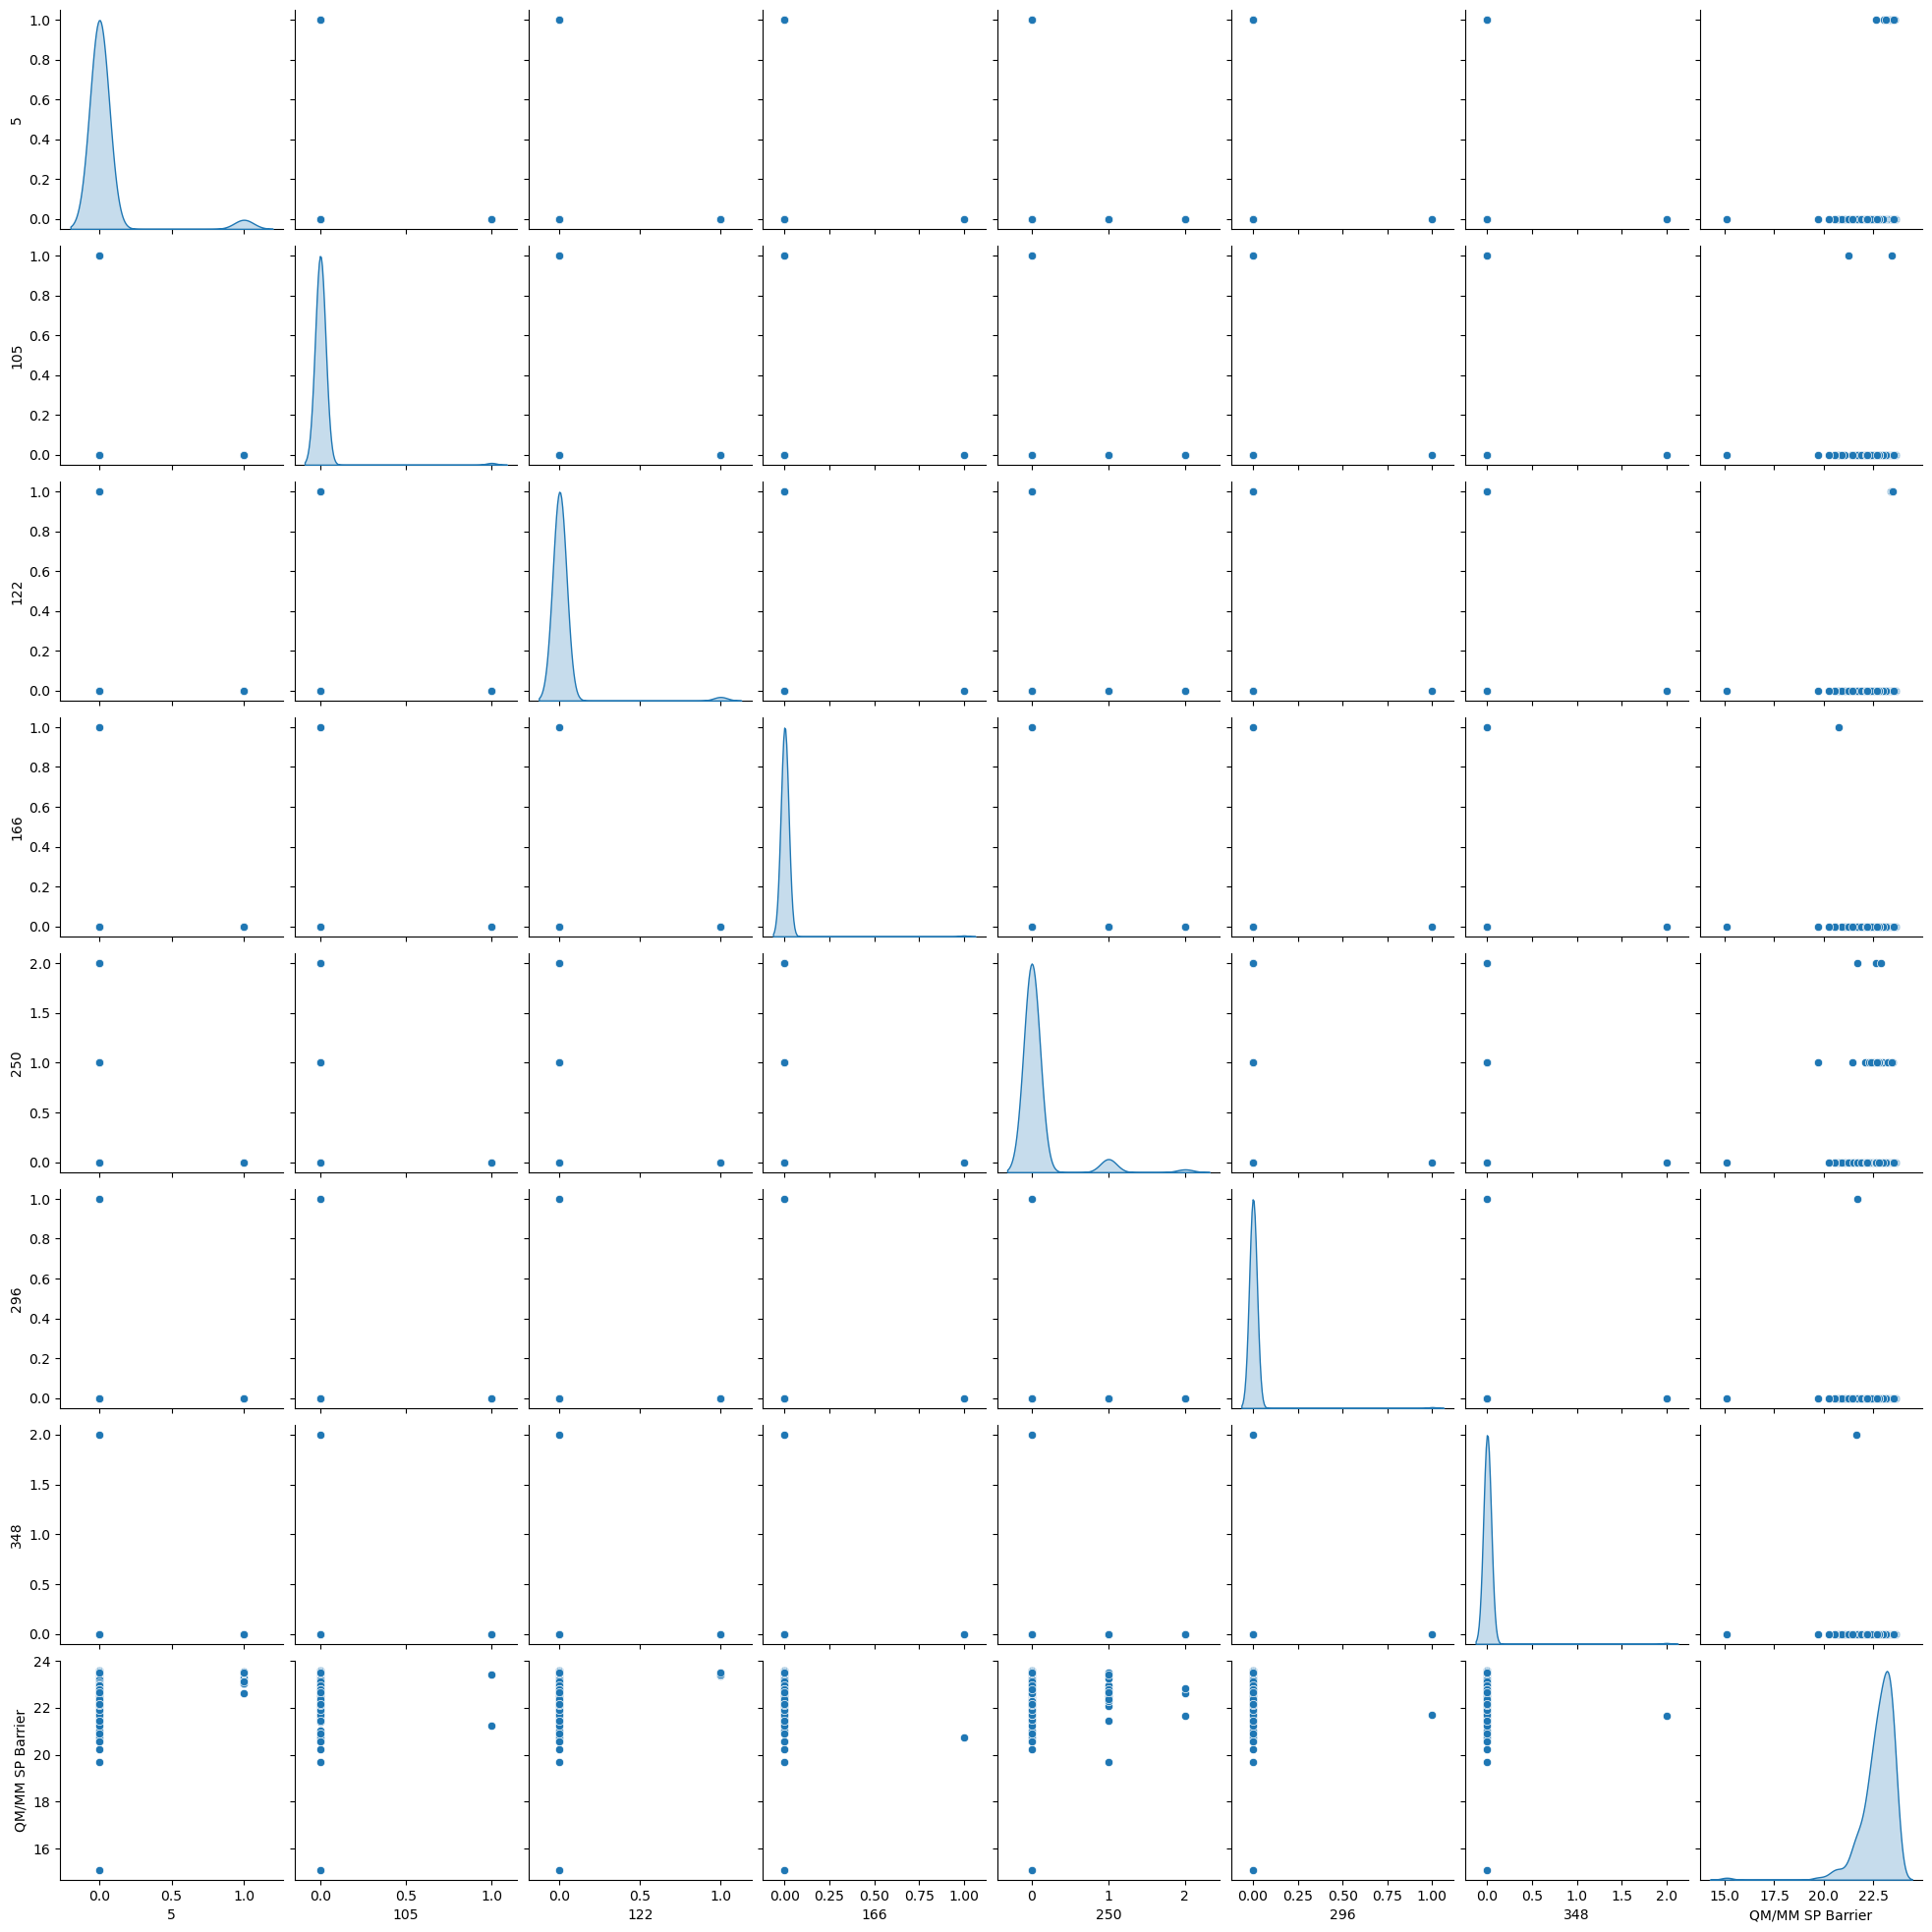

In [14]:
sns.pairplot(best_data_ft[['5', '105', '122', '166', '250', '296', '348' , 'QM/MM SP Barrier']], diag_kind="kde")

In [8]:
import matplotlib.pyplot as plt

# Number of columns in the dataframe
n_cols = len(best_data_ft.columns)

# Determine the size of the grid
cols_per_row = 5
n_rows = n_cols // cols_per_row + (n_cols % cols_per_row > 0)

# Create a larger figure to accommodate all the subplots
fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(25, 5 * n_rows))  # Increase figure size

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Set larger font sizes
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 12, 'axes.labelsize': 10})

# Loop through the dataframe columns
for i, col in enumerate(best_data_ft.columns):
    # Create histogram in the ith subplot
    axes[i].hist(best_data_ft[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust the layout
plt.tight_layout()
plt.show()

NameError: name 'best_data_ft' is not defined

In [15]:
best_data_ft.to_csv('/home/juan/Documents/Master_Project/data/best_low_feats_ext.csv')

## Other Feature selection

In [5]:
dataset = pd.read_csv('/home/juan/Documents/Master_Project/data/dataset-15-jan.csv')
dataset = dataset.iloc[:,1:]
dataset.head()

,atom_number,aromatic_Hcycles,aromatic_rings,amide_bonds,heavy_atoms,saturated_carbocycles,total_charge,0,1,2,...,C,N,H,O,F,S,P,Br,QM/MM SP Barrier,Folder
0,48,1,1,0,22,0,1,0,0,0,...,153,45,9,0,0,0,0,0,28.23,mol_35
1,48,1,1,0,22,0,1,0,0,0,...,153,45,9,0,0,0,0,0,30.09,mol_36
2,48,1,1,0,22,0,1,0,0,0,...,153,45,9,0,0,0,0,0,24.53,mol_37
3,48,1,1,0,22,0,1,0,0,0,...,153,45,9,0,0,0,0,0,27.80,mol_38
4,42,1,2,0,22,0,1,0,0,0,...,135,27,27,27,0,9,0,0,30.96,mol_39


## Add electronegativity

In [18]:
electronegativity = {
    "C": 2.55,
    "N": 3.04,
    "H": 2.20,
    "O": 3.44,
    "F": 3.98,
    "S": 2.58,
    "P": 2.19,
    "Br": 2.96}

def weighted_electronegativity(row):
    total_atoms = sum(row[elem] for elem in electronegativity.keys())
    weighted_sum = sum(row[elem] * electronegativity[elem] for elem in electronegativity.keys())
    return weighted_sum / total_atoms if total_atoms > 0 else 0

# Apply the function across the rows
dataset['Weighted Electronegativity'] = dataset.apply(weighted_electronegativity, axis=1)
cols = ['Weighted Electronegativity'] + [col for col in dataset if col != 'Weighted Electronegativity']
dataset = dataset[cols]

In [44]:
dataset = pd.read_csv('/home/juan/Documents/Master_Project/data/dataset-30-Jan.csv')
dataset = dataset.iloc[:,1:]
dataset.head()

,Weighted Electronegativity,atom_number,aromatic_Hcycles,aromatic_rings,amide_bonds,1019,heavy_atoms,total_charge,resname GTP,1,...,950,965,456,464,472,480,486,489,Folder,QM/MM SP Barrier
0,2.641304,48,1,1,0,1,22,1,13.951854,0,...,0,0,4,0,0,0,0,0,mol_35,28.23
1,2.641304,48,1,1,0,1,22,1,13.914320,0,...,0,0,4,0,0,0,0,0,mol_36,30.09
2,2.641304,48,1,1,0,1,22,1,14.090891,0,...,0,0,4,0,0,0,0,0,mol_37,24.53
3,2.641304,48,1,1,0,1,22,1,13.991196,0,...,0,0,4,0,0,0,0,0,mol_38,27.80
4,2.674800,42,1,2,0,1,22,1,13.840712,0,...,0,0,1,0,0,0,0,0,mol_39,30.96


In [45]:
features2 = dataset.iloc[:,:-2].values
target2 = dataset.iloc[:,-1].values
feature_names = dataset.iloc[:,:-2].columns

In [55]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

# Step 1: Apply Mutual Information or LASSO
mi_scores = mutual_info_regression(features2, target2)
selected_features_mi = np.argsort(mi_scores)[-100:]  

# Alternatively, use LASSO for feature selection
lasso = LassoCV().fit(features2, target2)
selected_features_lasso = np.nonzero(lasso.coef_)[0]

# Step 2: Apply Random Forest for feature importance
rf_model = RandomForestRegressor()
rf_model.fit(features2, target2)
feature_importance = rf_model.feature_importances_
selected_features_rf = np.argsort(feature_importance)[-100:]

# Step 3: Combine features
final_selected_features = set(selected_features_mi).intersection(selected_features_rf)
# or for LASSO: set(selected_features_lasso).intersection(selected_features_rf)


In [58]:
# Map indices to feature names
best_feats_list2 = [feature_names[i] for i in final_selected_features]

# Concatenate with the other column names
best_feats_columns2 = best_feats_list2 + ['Folder', 'QM/MM SP Barrier']

# Select specific columns from dataset and dataset_big
best_data_2 = dataset[best_feats_columns2]


In [59]:
best_data_2.head()

,Weighted Electronegativity,atom_number,aromatic_Hcycles,aromatic_rings,amide_bonds,1019,heavy_atoms,total_charge,resname GTP,1,...,950,965,456,464,472,480,486,489,Folder,QM/MM SP Barrier
0,2.641304,48,1,1,0,1,22,1,13.951854,0,...,0,0,4,0,0,0,0,0,mol_35,28.23
1,2.641304,48,1,1,0,1,22,1,13.914320,0,...,0,0,4,0,0,0,0,0,mol_36,30.09
2,2.641304,48,1,1,0,1,22,1,14.090891,0,...,0,0,4,0,0,0,0,0,mol_37,24.53
3,2.641304,48,1,1,0,1,22,1,13.991196,0,...,0,0,4,0,0,0,0,0,mol_38,27.80
4,2.674800,42,1,2,0,1,22,1,13.840712,0,...,0,0,1,0,0,0,0,0,mol_39,30.96


In [54]:
best_data_2.to_csv('/home/juan/Documents/Master_Project/data/dataset-30-Jan-22.csv')

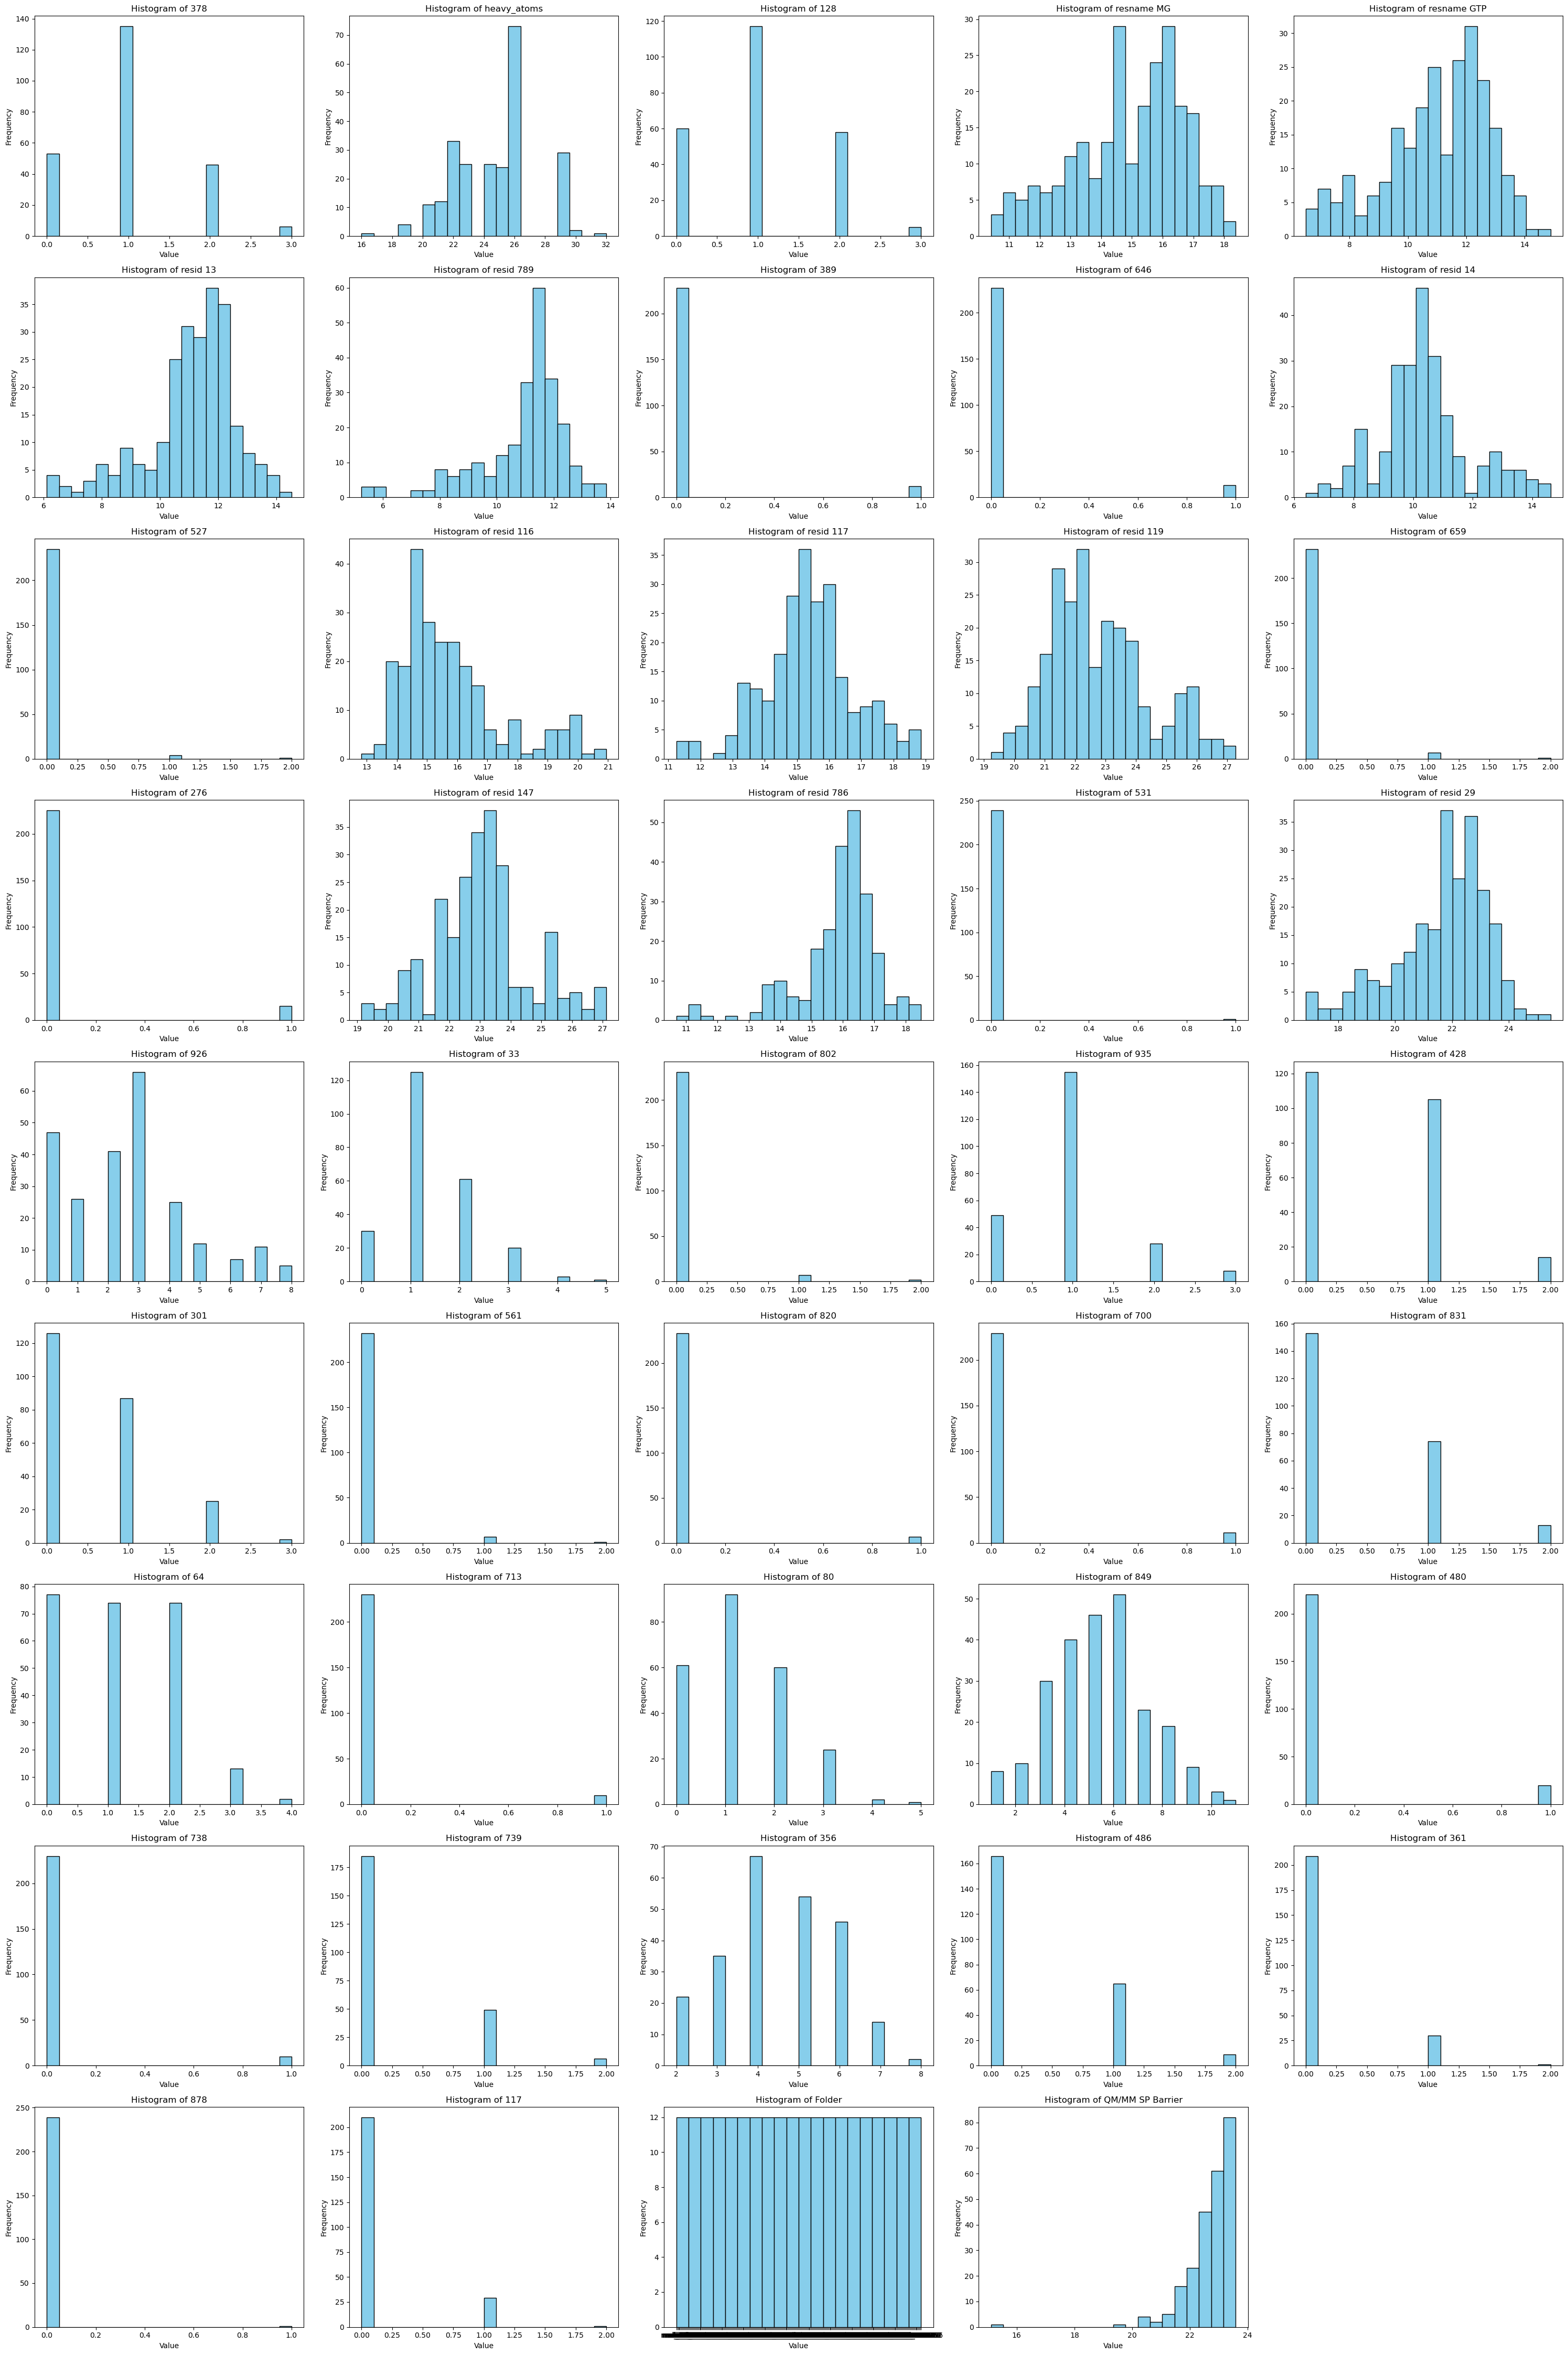

In [14]:
import matplotlib.pyplot as plt

# Number of columns in the dataframe
n_cols = len(best_data_2.columns)

# Determine the size of the grid
cols_per_row = 5
n_rows = n_cols // cols_per_row + (n_cols % cols_per_row > 0)

# Create a larger figure to accommodate all the subplots
fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(30, 5 * n_rows))  # Increase figure size

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Set larger font sizes
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 12, 'axes.labelsize': 10})

# Loop through the dataframe columns
for i, col in enumerate(best_data_2.columns):
    # Create histogram in the ith subplot
    axes[i].hist(best_data_2[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust the layout
plt.tight_layout()
plt.show()

In [17]:
best_data_2.to_csv('/home/juan/Documents/Master_Project/data/best_feats_multivariate_low.csv')
best_data_big2.to_csv('/home/juan/Documents/Master_Project/data/best_feats_multivariate.csv')

In [69]:
numerical_features = best_feats_columns2
sns.pairplot(best_data_2[numerical_features])
plt.show()

KeyboardInterrupt: 

In [72]:
best_data_2

,5,105,122,166,250,296,348,363,389,460,...,736,761,774,806,820,874,878,1014,Folder,QM/MM SP Barrier
36,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,mol_418,21.39
46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,mol_469,22.72
63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,mol_570,22.89
153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,mol_1840,23.23
155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,mol_1842,23.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,mol_173933,23.50
9672,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,mol_175433,22.78
9716,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,mol_176898,22.65
9723,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,mol_177162,22.18


In [73]:
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor


all_pearson = []


for i in tqdm(range(5)):
    # Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(best_data_2.iloc[:, :-2], best_data_2['QM/MM SP Barrier'], test_size=0.2)

    NN2 = RandomForestRegressor(
    n_estimators=600,      
    max_features='sqrt',
    max_depth=60,         
    min_samples_split=34,   
    min_samples_leaf=25,    
    bootstrap=True,        
    n_jobs=15,
    random_state=42, verbose=False)
    NN2.fit(X_train, Y_train)
    
    # Make predictions
    Y_pred2 = NN2.predict(X_test)
    
    # Calculate the Pearson correlation
    
    pearson_corr, _ = pearsonr(Y_test, Y_pred2)
    all_pearson.append(pearson_corr)


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


In [74]:
mean_pearson_corr = np.mean(all_pearson)
print(f"Mean Pearson correlation coefficient:{mean_pearson_corr}")

Mean Pearson correlation coefficient:0.20342016398706947


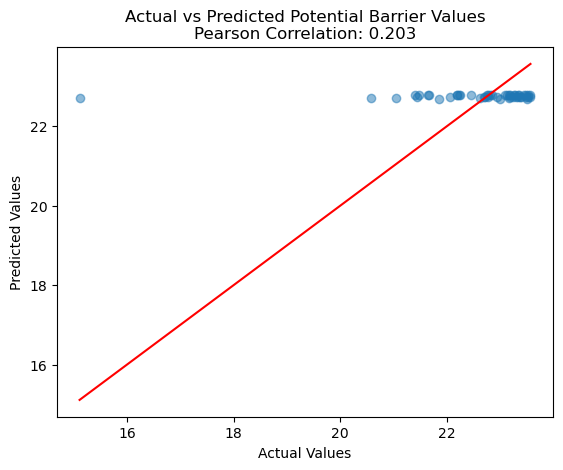

In [75]:
plt.scatter(Y_test, Y_pred2, alpha=0.5)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Potential Barrier Values\nPearson Correlation: {round(mean_pearson_corr, 3)}')
plt.show()

feature importance

In [76]:

from sklearn.inspection import permutation_importance


NN2.feature_importances_


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.48340139, 0.        , 0.        ,
       0.51659861, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

<BarContainer object of 100 artists>

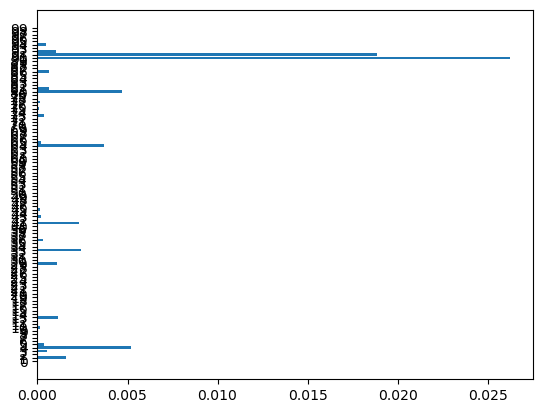

In [51]:
plt.barh(full_data.columns[:100], NN2.feature_importances_[:100])

In [77]:
data_feats = X_train.columns
feats_imp = NN2.feature_importances_

In [78]:
locations = np.argsort(feats_imp)[-100:][::-1]
new_feats_of_data=data_feats[locations]
new_data = dataset[new_feats_of_data]


KeyError: 'resid 29'

In [62]:

df_merged.to_csv('/home/juan/Documents/Master_Project/data/best_100_feats_ext.csv')

In [39]:
df_merged.tail()

,666,705,356,661,650,880,891,926,314,807,...,1005,1007,586,932,730,total_charge,842,838,QM/MM SP Barrier,Folder
9755,0,0,4,0,3,0,0,1,1,2,...,0,0,0,1,1,1,0,0,26.64,mol_178584
9756,0,0,4,0,3,0,0,1,1,2,...,0,0,0,1,1,1,0,0,29.72,mol_178586
9757,0,0,6,0,2,0,0,1,0,2,...,0,0,1,0,0,1,1,0,25.78,mol_178649
9758,0,0,8,0,2,0,0,0,1,1,...,0,0,1,0,1,1,0,0,31.07,mol_178787
9759,1,1,3,0,1,1,0,4,0,1,...,0,0,0,0,0,1,0,0,30.34,mol_178853


In [21]:
new_feats_of_data=data_feats[locations]

In [45]:
full_data.head()

,0,1,2,3,4,5,6,7,8,9,...,resid 29,total_charge,atom_number,aromatic_Hcycles,aromatic_rings,amide_bonds,heavy_atoms,saturated_carbocycles,QM/MM SP Barrier,Folder
0,0,0,0,0,1,0,0,0,0,0,...,23.531433,1,42,1,2,1,21,0,28.23,mol_35
1,0,0,0,0,1,0,0,0,0,0,...,23.802969,2,46,1,2,0,23,0,30.09,mol_36
2,0,0,0,0,1,0,0,0,0,0,...,23.984218,0,37,2,4,1,24,0,24.53,mol_37
3,0,0,0,0,1,0,0,0,0,0,...,23.882156,1,49,1,2,2,25,0,27.80,mol_38
4,0,0,0,0,0,0,0,0,0,0,...,23.930041,0,47,1,1,1,23,0,30.96,mol_39


In [23]:
new_data = full_data[new_feats_of_data]

In [26]:
df_merged = pd.merge(new_data, full_data[['resid 29', 'QM/MM SP Barrier', 'Folder']], on='resid 29', how='left')
df_merged.to_csv('/home/juan/Documents/Master_Project/data/best_feats.csv')

SMOGN upsampling regression

In [76]:
pip install git+https://github.com/nickkunz/smogn.git

  Cloning https://github.com/nickkunz/smogn.git to /tmp/pip-req-build-xs1ipk6d
  Running command git clone --filter=blob:none --quiet https://github.com/nickkunz/smogn.git /tmp/pip-req-build-xs1ipk6d
  Resolved https://github.com/nickkunz/smogn.git to commit e4e5e4aca43a07ebbd1a0ed881f4de1e24abb8ed
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [77]:
import smogn

In [78]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,resid 29,total_charge,atom_number,aromatic_Hcycles,aromatic_rings,amide_bonds,heavy_atoms,saturated_carbocycles,QM/MM SP Barrier,Folder
0,0,0,0,1,2,0,0,0,0,0,...,19.227805,1,37,2,4,1,24,0,27.66,mol_1457
1,0,0,0,1,0,0,0,0,0,0,...,20.971192,0,44,1,2,3,26,0,29.46,mol_6127
2,0,0,0,0,0,0,0,0,0,0,...,19.117503,0,55,0,1,3,29,0,26.50,mol_8393
3,0,0,0,1,1,0,0,0,0,0,...,19.203817,0,50,0,0,2,25,1,27.04,mol_8727
4,0,0,0,0,1,0,0,0,0,0,...,22.368210,0,43,1,3,2,26,0,27.86,mol_8787


In [221]:

## specify phi relevance values
rg_mtrx = [

    [36,  1, 0],  ## over-sample ("minority")
    [30, 0, 0],  ## under-sample ("majority")
    [25, 0, 0],  ## under-sample
    [33, 0, 0],
]

dataset_smogn = smogn.smoter(
    data = dataset,
    y='QM/MM SP Barrier',
    k = 9,
    samp_method = 'balance',
    drop_na_col = False,       ## boolean (True or False)
    drop_na_row = False,       ## boolean (True or False)
    replace = False,          ## boolean (True or False)

    ## phi relevance arguments
    rel_thres = 0.26,         ## real number (0 < R < 1)
    rel_method = 'manual',    ## string ('auto' or 'manual')
    # rel_xtrm_type = 'both', ## unused (rel_method = 'manual')
    # rel_coef = 1.50,        ## unused (rel_method = 'manual')
    rel_ctrl_pts_rg = rg_mtrx ## 2d array (format: [x, y])
)

r_index: 100%|##########| 2/2 [00:00<00:00, 106.58it/s]


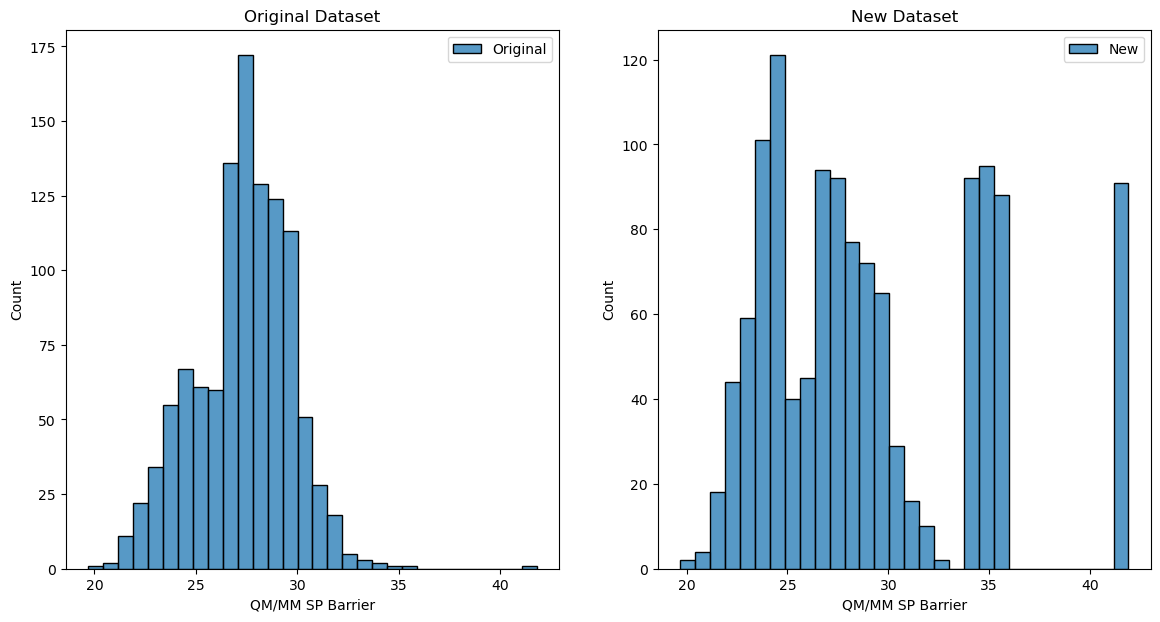

In [222]:
import seaborn as sns

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.histplot(dataset['QM/MM SP Barrier'], kde=False, bins=30, label='Original')
plt.title('Original Dataset')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(dataset_smogn['QM/MM SP Barrier'], kde=False, bins=30, label='New')
plt.title('New Dataset')
plt.legend()
plt.show()

In [186]:
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor


all_pearson_sm = []


for i in tqdm(range(100)):
    # Split the data
    X_train_sm, X_test_sm, Y_train_sm, Y_test_sm = train_test_split(dataset_smogn.iloc[:, :-2], dataset_smogn['QM/MM SP Barrier'], test_size=0.2)

    rf_sm = RandomForestRegressor(
    n_estimators=600,   
    max_features='sqrt',
    max_depth=60,
    min_samples_split=34, 
    min_samples_leaf=25,  
    bootstrap=True,   
    n_jobs=15,
    random_state=42, verbose=False)
    rf_sm.fit(X_train_sm, Y_train_sm)
    
    # Make predictions
    Y_pred2_sm = rf_sm.predict(X_test_sm)
    # Calculate the Pearson correlation
    
    pearson_corr_sm, _ = pearsonr(Y_test_sm, Y_pred2_sm)
    all_pearson_sm.append(pearson_corr_sm)


100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


In [187]:
mean_pearson_corr_sm = np.mean(all_pearson_sm)
print(f"Mean Pearson correlation coefficient:{mean_pearson_corr_sm}")

Mean Pearson correlation coefficient:0.641618488570726


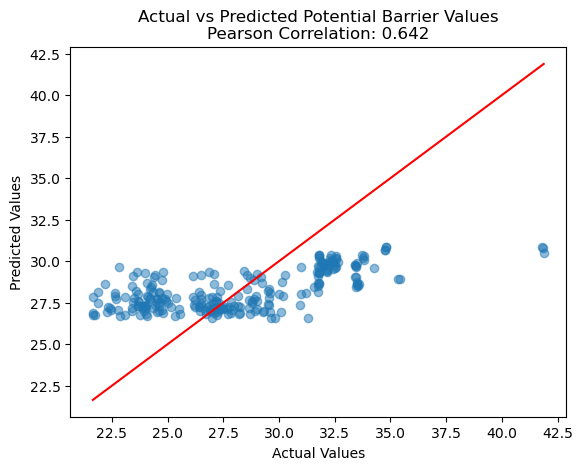

In [188]:
plt.scatter(Y_test_sm, Y_pred2_sm, alpha=0.5)
plt.plot([min(Y_test_sm), max(Y_test_sm)], [min(Y_test_sm), max(Y_test_sm)], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Potential Barrier Values\nPearson Correlation: {round(mean_pearson_corr_sm, 3)}')
plt.show()

In [189]:
ypred = rf_sm.predict(X_test)

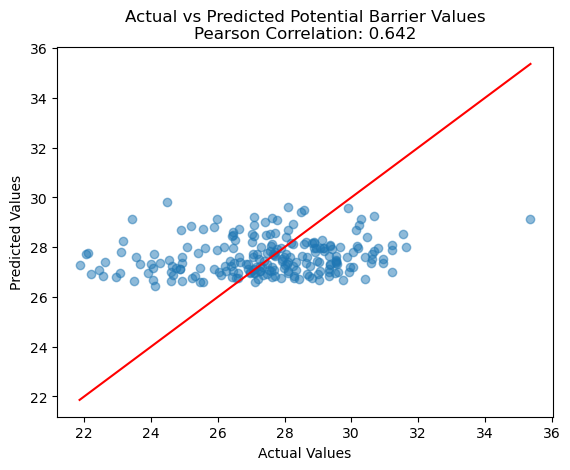

In [190]:
plt.scatter(Y_test, ypred, alpha=0.5)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Potential Barrier Values\nPearson Correlation: {round(mean_pearson_corr_sm, 3)}')
plt.show()

In [194]:
from sklearn.metrics import mean_absolute_error
mae1 = mean_absolute_error(Y_test, ypred)
mae2 = mean_absolute_error(Y_test,Y_pred2)

In [195]:
print(mae1,mae2)

1.71257635160365 1.7051615255196064


In [196]:
pearson_corr2, _ = pearsonr(Y_test, ypred)
print(pearson_corr2)

0.1916975642122379


## New features (LATEST)

In [6]:
import os
# Imports
import numpy as np
import os
import matplotlib.pyplot as plt
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from glob import glob
import MDAnalysis as mda
from MDAnalysis.analysis import distances
import warnings
warnings.filterwarnings('ignore')
import scipy.sparse
from natsort import natsorted
from MDAnalysis.lib.distances import (
           capped_distance,
           self_distance_array, distance_array,  # legacy reasons
)
from MDAnalysis.lib.c_distances import contact_matrix_no_pbc, contact_matrix_pbc
from MDAnalysis.lib.NeighborSearch import AtomNeighborSearch
from MDAnalysis.lib.distances import calc_bonds
import logging
logger = logging.getLogger("MDAnalysis.analysis.distances")
import os, subprocess
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from rdkit.Chem import DataStructs,AllChem
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
from IPython import embed as e
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdMolDescriptors import CalcNumAromaticRings
from rdkit.Chem.rdMolDescriptors import CalcNumAromaticHeterocycles
from rdkit.Chem.rdMolDescriptors import CalcNumAtoms

Error files: []


In [31]:
output_folder = "/home/juan/Documents/Master_Project/data/"
# Load data
path_folder = '/home/juan/Documents/Master_Project/data/pdb_6_dic/'
path_folder2 = '/home/juan/Documents/Master_Project/data/ligs_14_nov/pdb'
files = natsorted([fp for fp in os.listdir(path_folder2) if fp.endswith(".pdb") if "g12d" not in fp])

In [27]:
n_atoms = []
n_arm_hcycles = []
n_arm_rings = []
n_amidebs = []
sat_carbcs = []
heavy_atoms = []
total_charges = []
folder = []

for filen in files:
    # Remove .pdb extension
    filename_without_extension = filen.rstrip('.pdb')
    folder.append(filename_without_extension)

    file_path = os.path.join(path_folder2, filen)
    mol = Chem.MolFromPDBFile(file_path)
    if mol:
        n_atom = rdMolDescriptors.CalcNumAtoms(mol)
        n_atoms.append(n_atom)

        heavy_atom = rdMolDescriptors.CalcNumHeavyAtoms(mol)
        heavy_atoms.append(heavy_atom)

        sat_carbc = rdMolDescriptors.CalcNumSaturatedCarbocycles(mol)
        sat_carbcs.append(sat_carbc)

        n_arm_hcycle = rdMolDescriptors.CalcNumAromaticHeterocycles(mol)
        n_arm_hcycles.append(n_arm_hcycle)

        n_arm_ring = rdMolDescriptors.CalcNumAromaticRings(mol)
        n_arm_rings.append(n_arm_ring)

        n_amideb = rdMolDescriptors.CalcNumAmideBonds(mol)
        n_amidebs.append(n_amideb)

        # Calculate total charge
        total_charge = sum(atom.GetFormalCharge() for atom in mol.GetAtoms())
        total_charges.append(total_charge)

    else:
        print(f"Failed to read molecule from {filen}")
        pass


[13:09:17] Explicit valence for atom # 10 C, 5, is greater than permitted


Failed to read molecule from mol_3786.pdb


[13:09:18] Explicit valence for atom # 0 C, 5, is greater than permitted
[13:09:18] Explicit valence for atom # 0 C, 5, is greater than permitted
[13:09:18] Explicit valence for atom # 0 C, 5, is greater than permitted
[13:09:18] Explicit valence for atom # 0 C, 5, is greater than permitted


Failed to read molecule from mol_67490.pdb
Failed to read molecule from mol_67491.pdb
Failed to read molecule from mol_67492.pdb
Failed to read molecule from mol_67493.pdb


[13:09:21] Explicit valence for atom # 20 C, 5, is greater than permitted


Failed to read molecule from mol_110604.pdb


[13:09:21] Explicit valence for atom # 0 C, 5, is greater than permitted
[13:09:21] Explicit valence for atom # 0 C, 5, is greater than permitted
[13:09:21] Explicit valence for atom # 0 C, 5, is greater than permitted
[13:09:21] Explicit valence for atom # 0 C, 5, is greater than permitted


Failed to read molecule from mol_134068.pdb
Failed to read molecule from mol_134069.pdb
Failed to read molecule from mol_134076.pdb
Failed to read molecule from mol_134079.pdb


14-Nov files

In [38]:
files_to_delete2 = [
    "mol_3786.pdb",
    "mol_67490.pdb",
    "mol_67491.pdb",
    "mol_67492.pdb",
    "mol_67493.pdb",
    "mol_110604.pdb",
    "mol_134068.pdb",
    "mol_134069.pdb",
    "mol_134076.pdb",
    "mol_134079.pdb"
]

files = [file for file in files if file not in files_to_delete2]


06-December files

In [93]:
files_to_delete = 'mol_130112.pdb'

if files_to_delete in files:
    files.remove(files_to_delete)
    print(f"Item '{files_to_delete}' deleted successfully.")
else:
    print(f"Item '{files_to_delete}' not found in the list.")

Item 'mol_130112.pdb' deleted successfully.


In [99]:
path_folder

'/home/juan/Documents/Master_Project/data/pdb_6_dic/'

##### atom counts

In [40]:
import os
import pandas as pd

def count_atoms(path_folder, files):
    data = []
    for file in files:
        file_path = os.path.join(path_folder, file)
        carbon_count = 0
        nitrogen_count = 0
        fluor_count = 0
        oxygen_count = 0
        hydrogen_count = 0
        with open(file_path, 'r') as file_obj:
            for line in file_obj:
                if line.startswith("ATOM"):
                    atom_type = line[76:78].strip()  # Extract the element type from columns 77-78
                    if atom_type == "C":
                        carbon_count += 1
                    elif atom_type == "H":
                        hydrogen_count += 1
                    elif atom_type == "O":
                        oxygen_count += 1
                    elif atom_type == "F":
                        fluor_count += 1
                    elif atom_type == "N":
                        nitrogen_count += 1
                    else:
                        print(f"Non-C/N atom identified in {file}: {atom_type}")
        data.append((file, carbon_count, nitrogen_count, hydrogen_count, oxygen_count, fluor_count))

    return pd.DataFrame(data, columns=['Filename', 'C', 'N', 'H', 'O', 'F'])

atom_counts_df = count_atoms(path_folder2, files)

atom_counts_df.head()


Non-C/N atom identified in mol_39.pdb: S
Non-C/N atom identified in mol_39.pdb: S
Non-C/N atom identified in mol_39.pdb: S
Non-C/N atom identified in mol_39.pdb: S
Non-C/N atom identified in mol_39.pdb: S
Non-C/N atom identified in mol_39.pdb: S
Non-C/N atom identified in mol_39.pdb: S
Non-C/N atom identified in mol_39.pdb: S
Non-C/N atom identified in mol_39.pdb: S
Non-C/N atom identified in mol_42.pdb: S
Non-C/N atom identified in mol_42.pdb: S
Non-C/N atom identified in mol_42.pdb: S
Non-C/N atom identified in mol_42.pdb: S
Non-C/N atom identified in mol_42.pdb: S
Non-C/N atom identified in mol_42.pdb: S
Non-C/N atom identified in mol_42.pdb: S
Non-C/N atom identified in mol_42.pdb: S
Non-C/N atom identified in mol_42.pdb: S
Non-C/N atom identified in mol_165.pdb: S
Non-C/N atom identified in mol_165.pdb: S
Non-C/N atom identified in mol_165.pdb: S
Non-C/N atom identified in mol_165.pdb: S
Non-C/N atom identified in mol_165.pdb: S
Non-C/N atom identified in mol_165.pdb: S
Non-C/N at

,Filename,C,N,H,O,F
0,mol_35.pdb,153,45,9,0,0
1,mol_36.pdb,153,45,9,0,0
2,mol_37.pdb,153,45,9,0,0
3,mol_38.pdb,153,45,9,0,0
4,mol_39.pdb,135,27,27,27,0


In [41]:
import os
import pandas as pd

def count_atoms(path_folder, files):
    data = []
    for file in files:
        file_path = os.path.join(path_folder, file)
        carbon_count = 0
        nitrogen_count = 0
        fluor_count = 0
        oxygen_count = 0
        hydrogen_count = 0
        sulfur_count = 0
        phos_count = 0
        bro_count = 0
        with open(file_path, 'r') as file_obj:
            for line in file_obj:
                if line.startswith("ATOM"):
                    elements = line.split()
                    atom_type = elements[2]
                    # Check for the first character of atom_type
                    first_char = atom_type[0]
                    if first_char == "C":
                        carbon_count += 1
                    elif first_char == "H":
                        hydrogen_count += 1
                    elif first_char == "O":
                        oxygen_count += 1
                    elif first_char == "F":
                        fluor_count += 1
                    elif first_char == "N":
                        nitrogen_count += 1
                    elif first_char == "S":
                        sulfur_count += 1
                    elif first_char == "P":
                        phos_count += 1
                    elif atom_type.startswith("Br") or atom_type.startswith("BR"):
                        bro_count += 1
                    else:
                        print(f"Non-C/N/... atom identified in {file}: {atom_type}")
        data.append((file.strip('.pdb'), carbon_count, nitrogen_count, hydrogen_count, oxygen_count, fluor_count, sulfur_count, phos_count, bro_count))

    return pd.DataFrame(data, columns=['Folder', 'C', 'N', 'H', 'O', 'F', 'S', 'P', 'Br'])

atom_counts_df = count_atoms(path_folder2, files)

atom_counts_df.head()


,Folder,C,N,H,O,F,S,P,Br
0,mol_35,153,45,9,0,0,0,0,0
1,mol_36,153,45,9,0,0,0,0,0
2,mol_37,153,45,9,0,0,0,0,0
3,mol_38,153,45,9,0,0,0,0,0
4,mol_39,135,27,27,27,0,9,0,0


Merge with dataset_ext

In [37]:
dataset_ext = pd.read_csv('/home/juan/Documents/Master_Project/data/best_feats_multivariate.csv')
dataset_ext = dataset_ext.iloc[:,1:]
dataset_ext.head()

,378,heavy_atoms,128,resname MG,resname GTP,resid 13,resid 789,389,646,resid 14,...,480,738,739,356,486,361,878,117,Folder,QM/MM SP Barrier
0,1,22,0,17.927591,13.951854,12.927288,13.695886,0,0,10.391891,...,0,0,0,2,0,0,0,0,mol_35,28.23
1,1,22,0,17.987640,13.914320,12.949490,13.435519,0,0,11.045068,...,0,0,0,2,0,0,0,0,mol_36,30.09
2,1,22,0,18.166830,14.090891,13.128346,13.589793,0,0,11.231185,...,0,0,0,2,0,0,0,0,mol_37,24.53
3,1,22,0,18.047638,13.991196,13.051387,13.628988,0,0,11.003977,...,0,0,0,2,0,0,0,0,mol_38,27.80
4,1,22,0,17.886824,13.840712,13.068806,13.716762,0,0,11.027704,...,0,0,1,4,0,0,0,0,mol_39,30.96


In [104]:
merge = pd.merge(atom_counts_df, dataset_ext, on='Folder', how='inner')
merge.head()

,Folder,C,N,H,O,F,S,P,Br,378,...,849,480,738,739,356,486,361,878,117,QM/MM SP Barrier
0,mol_44,18,3,0,2,0,0,0,0,1,...,5,0,0,1,4,0,0,0,0,30.14
1,mol_91,15,3,0,2,3,0,0,0,1,...,2,0,0,1,3,0,0,0,0,26.27
2,mol_923,15,3,2,2,2,1,0,0,1,...,5,0,0,0,4,0,0,0,0,24.36
3,mol_2395,15,4,2,2,1,0,0,0,1,...,5,0,0,0,5,0,0,0,0,29.45
4,mol_2397,16,4,2,2,1,0,0,0,1,...,5,0,0,0,5,0,0,0,0,29.12


In [105]:
columns_to_move = ['QM/MM SP Barrier', 'Folder']

# Get the list of all column names
all_columns = list(merge.columns)

# Remove the names of the columns to be moved
for column_name in columns_to_move:
    all_columns.remove(column_name)

# Append the columns to be moved to the end of the list
all_columns.extend(columns_to_move)

# Reorder the DataFrame columns
merge = merge[all_columns]
merge.head()

,C,N,H,O,F,S,P,Br,378,heavy_atoms,...,480,738,739,356,486,361,878,117,QM/MM SP Barrier,Folder
0,18,3,0,2,0,0,0,0,1,23,...,0,0,1,4,0,0,0,0,30.14,mol_44
1,15,3,0,2,3,0,0,0,1,23,...,0,0,1,3,0,0,0,0,26.27,mol_91
2,15,3,2,2,2,1,0,0,1,23,...,0,0,0,4,0,0,0,0,24.36,mol_923
3,15,4,2,2,1,0,0,0,1,22,...,0,0,0,5,0,0,0,0,29.45,mol_2395
4,16,4,2,2,1,0,0,0,1,23,...,0,0,0,5,0,0,0,0,29.12,mol_2397


In [86]:
merge.to_csv('/home/juan/Documents/Master_Project/data/dataset-small-15-jan.csv')

## Feats 9-03

In [44]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Crippen

def extract_pdb_features(pdb_file):
    mol = Chem.MolFromPDBFile(pdb_file)
    if mol is None:
        print("Error: Unable to read PDB file.")
        return None
    
    # Calculate the number of bonds
    nBonds = mol.GetNumBonds()
    
    # Initialize the bond type counts
    nBonds2 = 0
    nBondsD = 0
    nBondsT = 0
    nBondsM = 0
    
    # Loop through each bond to count the types
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.SINGLE:
            nBonds2 += 1
        elif bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            nBondsD += 1
        elif bond.GetBondType() == Chem.rdchem.BondType.TRIPLE:
            nBondsT += 1
        elif bond.GetBondType() == Chem.rdchem.BondType.AROMATIC:
            nBondsM += 1
    # Calculate counts of rings of different sizes
    ri = mol.GetRingInfo()
    ring_sizes = [len(ring) for ring in ri.AtomRings()]
    nRing = len(ring_sizes)
    n3Ring = ring_sizes.count(3)
    n4Ring = ring_sizes.count(4)
    n5Ring = ring_sizes.count(5)
    n6Ring = ring_sizes.count(6)
    n7Ring = ring_sizes.count(7)
    n8Ring = ring_sizes.count(8)
    nMoreRing = sum(1 for size in ring_sizes if size > 8)

    # Initialize counts for rings containing heteroatoms
    heteroatom_ring_counts = {
        'Total Heteroatom Rings': 0,
        '3-Membered Heteroatom Rings': 0,
        '4-Membered Heteroatom Rings': 0,
        '5-Membered Heteroatom Rings': 0,
        '6-Membered Heteroatom Rings': 0,
        '7-Membered Heteroatom Rings': 0,
        '12-Membered Heteroatom Rings': 0,
        'More than 12-Membered Heteroatom Rings': 0
    }

    # Ensure that Chem.GetSymmSSSR(mol) returns ring objects
    ring_objs = list(Chem.GetSymmSSSR(mol))
    ring_objs = [list(vec) for vec in ring_objs]

    if isinstance(ring_objs, int):
        # No rings found, set ring-related counts to 0
        nRing = 0
    else:
        # Iterate over each ring in the molecule
        # Iterate over each ring in the molecule
        for ring in ring_objs:
            # Check if the ring contains heteroatoms
            if any(mol.GetAtomWithIdx(atom).GetAtomicNum() != 6 for atom in ring):
                heteroatom_ring_counts['Total Heteroatom Rings'] += 1

                # Categorize the heteroatom-containing rings based on the number of atoms they contain
                num_atoms = len(ring)
                if num_atoms == 3:
                    heteroatom_ring_counts['3-Membered Heteroatom Rings'] += 1
                elif num_atoms == 4:
                    heteroatom_ring_counts['4-Membered Heteroatom Rings'] += 1
                elif num_atoms == 5:
                    heteroatom_ring_counts['5-Membered Heteroatom Rings'] += 1
                elif num_atoms == 6:
                    heteroatom_ring_counts['6-Membered Heteroatom Rings'] += 1
                elif num_atoms == 7:
                    heteroatom_ring_counts['7-Membered Heteroatom Rings'] += 1
                elif num_atoms == 12:
                    heteroatom_ring_counts['12-Membered Heteroatom Rings'] += 1
                else:
                    heteroatom_ring_counts['More than 12-Membered Heteroatom Rings'] += 1

    # Return the extracted features
    features = {
        'nBonds': nBonds,
        'nBondsD': nBondsD,
        'nBonds2': nBonds2,
        'nBondsT': nBondsT,
        'nBondsM': nBondsM,
        'pubchemcomplexity': rdMolDescriptors.CalcCrippenDescriptors(mol)[0],
        'pubchemhbondacceptor': rdMolDescriptors.CalcNumLipinskiHBA(mol),
        'pubchemhbonddonor': rdMolDescriptors.CalcNumLipinskiHBD(mol),
        'pubchemrotbon': rdMolDescriptors.CalcNumRotatableBonds(mol),
        'pubchemlogp': Crippen.MolLogP(mol),
        'pubchemmass': Descriptors.MolWt(mol),
        'pubchemtsa': rdMolDescriptors.CalcTPSA(mol),
        'nRing': nRing,
        'n3Ring': n3Ring,
        'n4Ring': n4Ring,
        'n5Ring': n5Ring,
        'n6Ring': n6Ring,
        'n7Ring': n7Ring,
        'n8Ring': n8Ring,
        'nMoreRing': nMoreRing,
        **heteroatom_ring_counts
    }
    return features
        

# Function to extract features from all PDB files in a given directory and return a DataFrame
def extract_features_from_directory(directory_path):
    features_list = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".pdb"):
            file_path = os.path.join(directory_path, filename)
            features = extract_pdb_features(file_path)
            if features is not None:
                features['Folder'] = filename.strip(".pdb")  # Add the filename to the features
                features_list.append(features)
    
    return pd.DataFrame(features_list)

# Path to the directory containing PDB files
directory_path = '/home/juan/Documents/Master_Project/data/correct_pdb_ext'

# Extract features and create DataFrame
df = extract_features_from_directory(directory_path)
df.head()

[13:01:20] Explicit valence for atom # 0 C, 5, is greater than permitted


Error: Unable to read PDB file.


[13:01:20] Explicit valence for atom # 0 C, 5, is greater than permitted


Error: Unable to read PDB file.


[13:01:22] Explicit valence for atom # 0 C, 5, is greater than permitted


Error: Unable to read PDB file.


[13:01:24] Explicit valence for atom # 0 C, 5, is greater than permitted


Error: Unable to read PDB file.


[13:01:30] Explicit valence for atom # 0 C, 5, is greater than permitted
[13:01:30] Explicit valence for atom # 0 C, 5, is greater than permitted


Error: Unable to read PDB file.
Error: Unable to read PDB file.


[13:01:40] Explicit valence for atom # 0 C, 5, is greater than permitted


Error: Unable to read PDB file.


[13:01:43] Explicit valence for atom # 0 C, 5, is greater than permitted


Error: Unable to read PDB file.


[13:01:53] Explicit valence for atom # 20 C, 5, is greater than permitted


Error: Unable to read PDB file.


[13:01:54] Explicit valence for atom # 10 C, 5, is greater than permitted


Error: Unable to read PDB file.


,nBonds,nBondsD,nBonds2,nBondsT,nBondsM,pubchemcomplexity,pubchemhbondacceptor,pubchemhbonddonor,pubchemrotbon,pubchemlogp,...,nMoreRing,Total Heteroatom Rings,3-Membered Heteroatom Rings,4-Membered Heteroatom Rings,5-Membered Heteroatom Rings,6-Membered Heteroatom Rings,7-Membered Heteroatom Rings,12-Membered Heteroatom Rings,More than 12-Membered Heteroatom Rings,Folder
0,23,1,11,0,11,0.39820,5,2,4,0.39820,...,0,2,0,0,2,0,0,0,0,mol_134810
1,26,0,14,0,12,3.35790,4,0,3,3.35790,...,0,2,0,0,1,1,0,0,0,mol_147462
2,27,2,5,0,20,1.33280,8,2,3,1.33280,...,0,2,0,0,2,0,0,0,0,mol_152261
3,27,2,14,0,11,1.79150,6,1,7,1.79150,...,0,2,0,0,2,0,0,0,0,mol_22419
4,24,1,16,1,6,1.46888,6,0,6,1.46888,...,0,2,0,0,0,2,0,0,0,mol_469


In [54]:
df_all = pd.read_csv('/home/juan/Documents/Master_Project/data/dataset_ext_ALLB.csv')
df_all = df_all.iloc[:,1:]
df_all.tail()

,Weighted Electronegativity,C,N,H,O,F,S,P,Br,0,...,box_71,box_72,box_73,box_74,box_75,box_76,box_77,box_78,box_79,box_80
9755,2.690345,18,5,3,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9756,2.690345,18,5,3,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9757,2.692143,20,3,2,2,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9758,2.676071,19,5,2,2,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9759,2.661786,19,6,2,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
merged_dataset = pd.merge(df, df_all, on="Folder")
merged_dataset = merged_dataset[[col for col in merged_dataset.columns if col not in ['Folder', 'QM/MM SP Barrier']] + ['Folder', 'QM/MM SP Barrier']]

merged_dataset.head()

,nBonds,nBondsD,nBonds2,nBondsT,nBondsM,pubchemcomplexity,pubchemhbondacceptor,pubchemhbonddonor,pubchemrotbon,pubchemlogp,...,box_73,box_74,box_75,box_76,box_77,box_78,box_79,box_80,Folder,QM/MM SP Barrier
0,23,1,11,0,11,0.39820,5,2,4,0.39820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_134810,29.71
1,26,0,14,0,12,3.35790,4,0,3,3.35790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_147462,28.33
2,27,2,5,0,20,1.33280,8,2,3,1.33280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_152261,27.40
3,27,2,14,0,11,1.79150,6,1,7,1.79150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_22419,28.28
4,24,1,16,1,6,1.46888,6,0,6,1.46888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_469,22.72


In [57]:
merged_dataset.to_csv("/home/juan/Documents/Master_Project/data/dataset-09-03.csv", index=False)
